# 3º PRUEBA VGG16

In [26]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
color = 'rgb' #'grayscale' o 'rgb'

escala = 150

In [3]:
def cargar_datos(path1, path2, escala = escala, color = color):
    
    EMD = os.listdir(path1)
    NO_EMD = os.listdir(path2)
    
    data = []
    labels = []

    for i in EMD:   
        image=tf.keras.preprocessing.image.load_img(path1+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(1)
    for i in NO_EMD:   
        image=tf.keras.preprocessing.image.load_img(path2+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(0)
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

### TRAIN: OCT + iPhone + Samsung

### TEST: iPhone

In [4]:
dataset_iphone = cargar_datos('Datos EMD/iPhone/EMD', 'Datos EMD/iPhone/NO EMD')

In [5]:
dataset_samsung = cargar_datos('Datos EMD/Samsung/EMD', 'Datos EMD/Samsung/NO EMD')

In [6]:
dataset = cargar_datos('Datos EMD/OCT/EMD', 'Datos EMD/OCT/NO EMD')

In [20]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_ds = np.concatenate((train_ds, dataset_iphone[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

train_labels = np.concatenate((train_labels, dataset_iphone[1]))

In [21]:
print(len(train_ds)==len(train_labels))

True


In [22]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [23]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [24]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

553467096/553467096 [==============================] - 413s 1us/step


In [25]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
9/9 [==============================] - 11s 1s/step - loss: 3.8629 - accuracy: 0.6255 - val_loss: 5.1777 - val_accuracy: 0.1194
Epoch 2/200
9/9 [==============================] - 12s 1s/step - loss: 1.2109 - accuracy: 0.7116 - val_loss: 5.7434 - val_accuracy: 0.0448
Epoch 3/200
9/9 [==============================] - 13s 1s/step - loss: 0.6581 - accuracy: 0.7640 - val_loss: 2.7479 - val_accuracy: 0.2090
Epoch 4/200
9/9 [==============================] - 13s 1s/step - loss: 0.3351 - accuracy: 0.8689 - val_loss: 1.5307 - val_accuracy: 0.5224
Epoch 5/200
9/9 [==============================] - 12s 1s/step - loss: 0.2597 - accuracy: 0.8801 - val_loss: 1.1022 - val_accuracy: 0.6119
Epoch 6/200
9/9 [==============================] - 13s 1s/step - loss: 0.1568 - accuracy: 0.9438 - val_loss: 0.6685 - val_accuracy: 0.7612
Epoch 7/200
9/9 [==============================] - 13s 1s/step - loss: 0.0630 - accuracy: 0.9813 - val_loss: 2.2680 - val_accuracy: 0.4179
Epoch 8/200
9/9 [==========

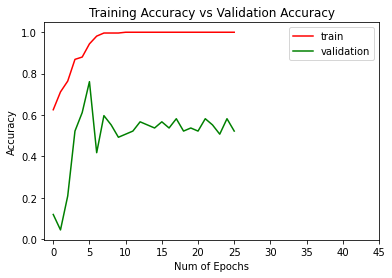

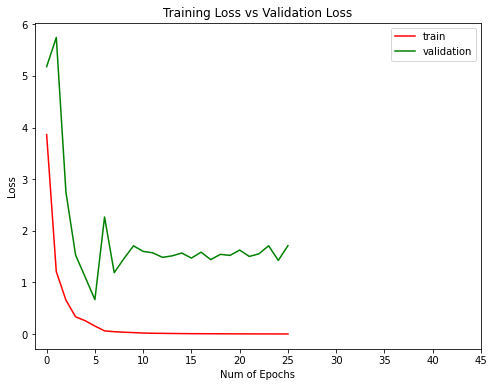

In [15]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

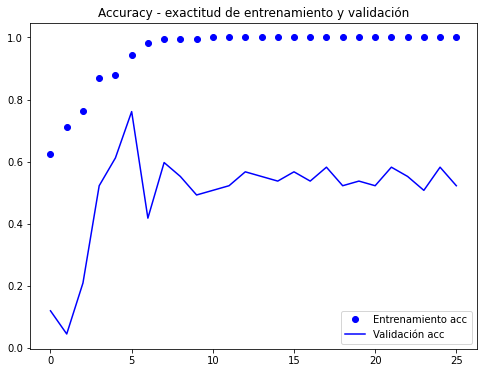

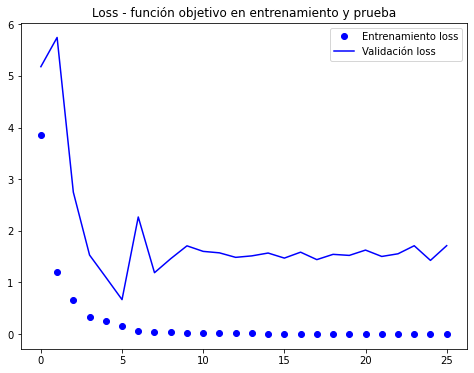

In [16]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 4s 817ms/step


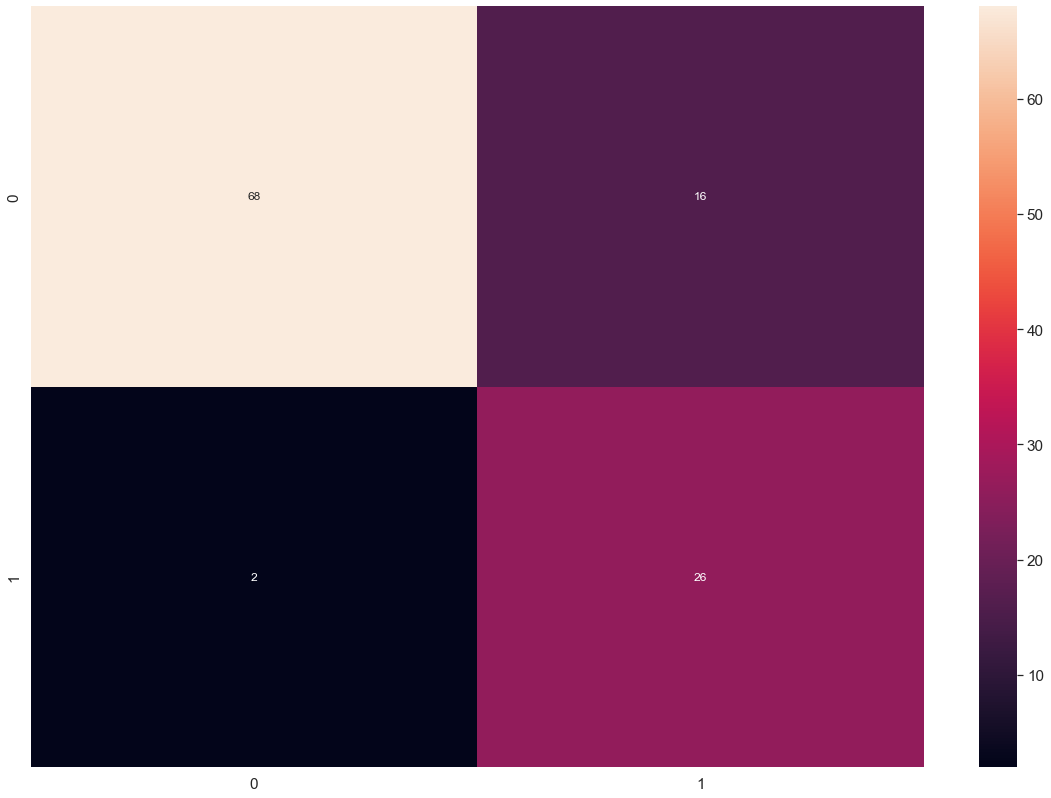

In [17]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

### TRAIN: OCT + iPhone + Samsung

### TEST: Samsung

In [18]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_ds = np.concatenate((train_ds, dataset_iphone[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

train_labels = np.concatenate((train_labels, dataset_iphone[1]))

In [19]:
test_ds = dataset_samsung[0]

test_labels = dataset_samsung[1]

In [20]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [21]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [22]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
9/9 [==============================] - 11s 1s/step - loss: 6.1548 - accuracy: 0.5955 - val_loss: 0.4658 - val_accuracy: 0.8806
Epoch 2/200
9/9 [==============================] - 12s 1s/step - loss: 1.6495 - accuracy: 0.6667 - val_loss: 0.5500 - val_accuracy: 0.7761
Epoch 3/200
9/9 [==============================] - 12s 1s/step - loss: 0.5487 - accuracy: 0.8090 - val_loss: 1.4204 - val_accuracy: 0.5821
Epoch 4/200
9/9 [==============================] - 12s 1s/step - loss: 0.2559 - accuracy: 0.9101 - val_loss: 1.3378 - val_accuracy: 0.5672
Epoch 5/200
9/9 [==============================] - 12s 1s/step - loss: 0.1271 - accuracy: 0.9513 - val_loss: 1.8740 - val_accuracy: 0.4776
Epoch 6/200
9/9 [==============================] - 12s 1s/step - loss: 0.0778 - accuracy: 0.9700 - val_loss: 1.6536 - val_accuracy: 0.5373
Epoch 7/200
9/9 [==============================] - 12s 1s/step - loss: 0.0543 - accuracy: 0.9850 - val_loss: 2.1619 - val_accuracy: 0.4776
Epoch 8/200
9/9 [==========

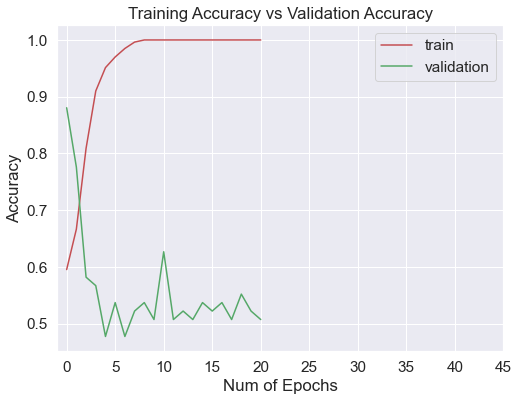

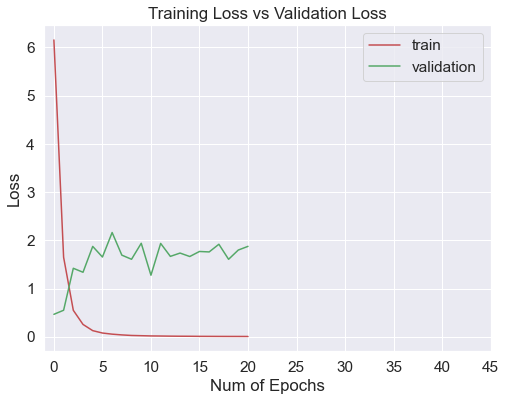

In [24]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

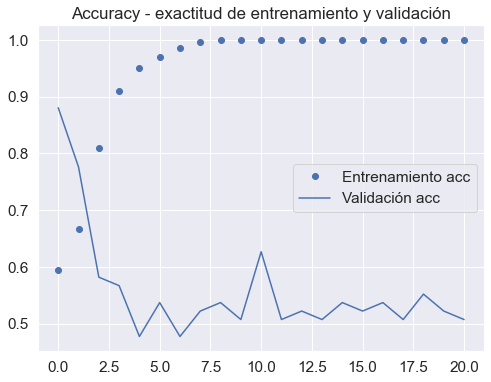

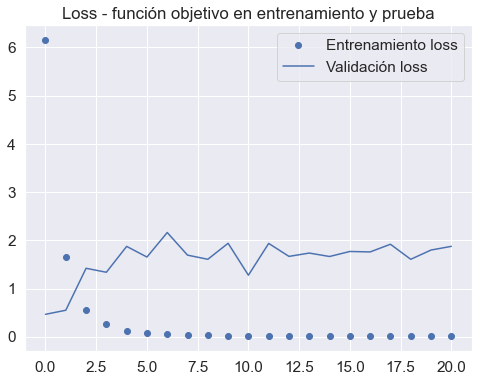

In [25]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 3s 749ms/step


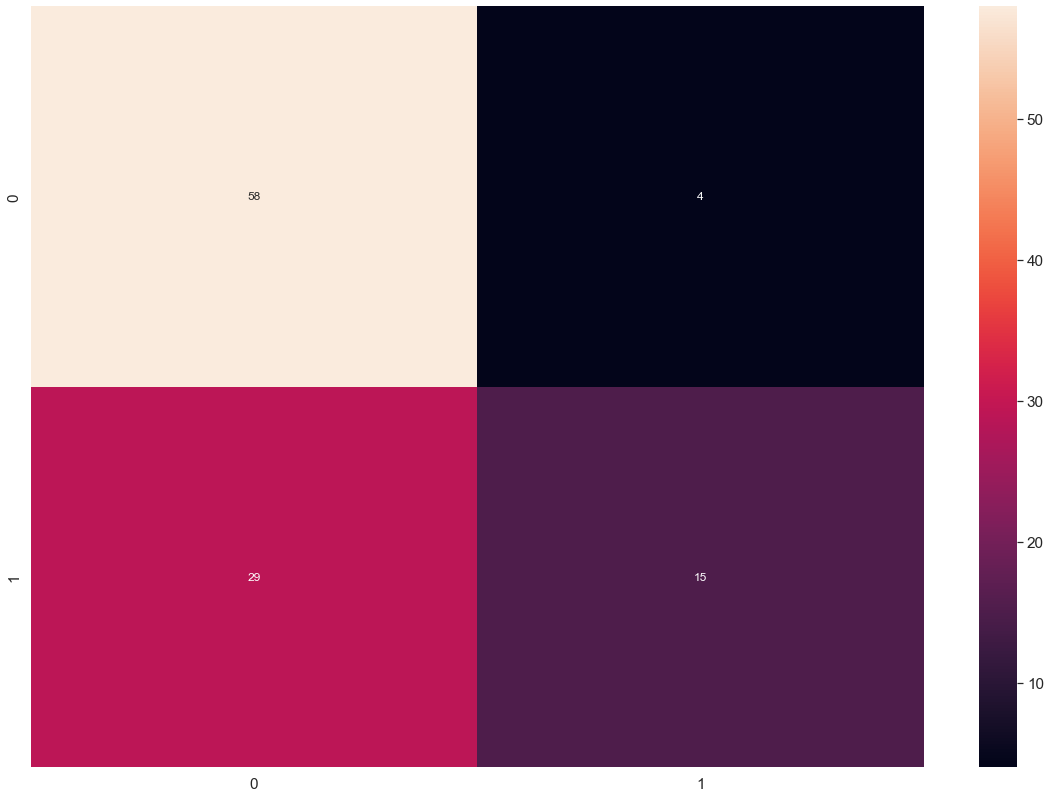

In [26]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

### TRAIN: OCT + iPhone

### TEST: Samsung

In [7]:
train_ds = np.concatenate((dataset[0],dataset_iphone[0]))

train_labels = np.concatenate((dataset[1],dataset_iphone[1]))

In [8]:
test_ds = dataset_samsung[0]

test_labels = dataset_samsung[1]

In [9]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [10]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [11]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
6/6 [==============================] - 8s 1s/step - loss: 2.8908 - accuracy: 0.6264 - val_loss: 1.7550 - val_accuracy: 0.6522
Epoch 2/200
6/6 [==============================] - 7s 1s/step - loss: 0.6745 - accuracy: 0.7912 - val_loss: 2.9848 - val_accuracy: 0.4348
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 0.5562 - accuracy: 0.8077 - val_loss: 0.1362 - val_accuracy: 0.9348
Epoch 4/200
6/6 [==============================] - 8s 1s/step - loss: 0.4499 - accuracy: 0.8571 - val_loss: 1.6545 - val_accuracy: 0.6304
Epoch 5/200
6/6 [==============================] - 8s 1s/step - loss: 0.1716 - accuracy: 0.9341 - val_loss: 0.8843 - val_accuracy: 0.8043
Epoch 6/200
6/6 [==============================] - 8s 1s/step - loss: 0.1747 - accuracy: 0.9451 - val_loss: 1.6143 - val_accuracy: 0.6739
Epoch 7/200
6/6 [==============================] - 8s 1s/step - loss: 0.1252 - accuracy: 0.9341 - val_loss: 1.0238 - val_accuracy: 0.8043
Epoch 8/200
6/6 [=================

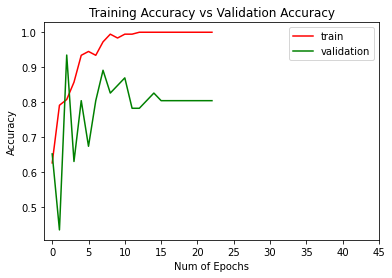

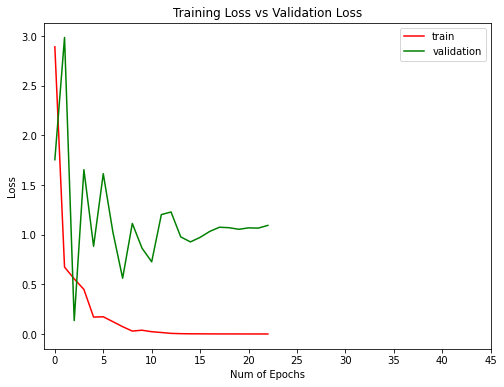

In [14]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

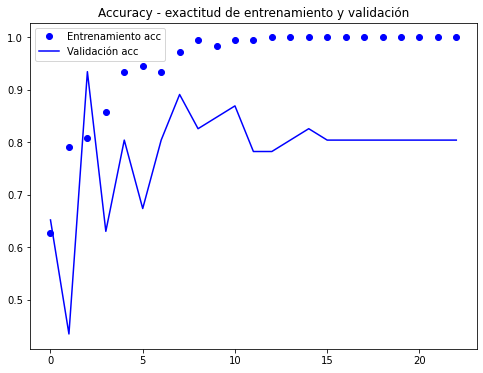

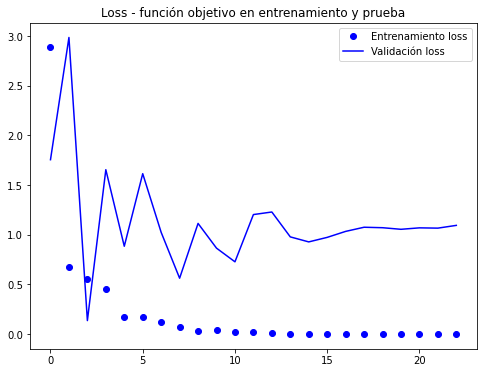

In [15]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 3s 748ms/step


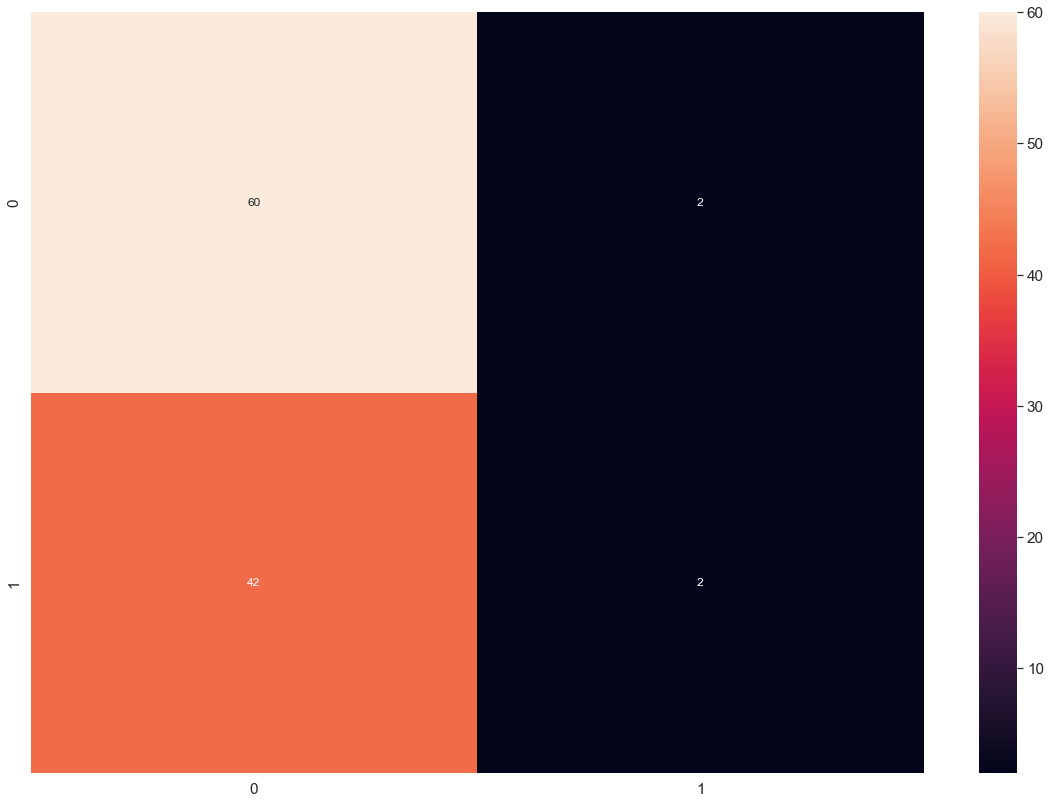

In [16]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

**MÉTRICAS DE EVALUACIÓN**

In [17]:
score_test = model.evaluate(x=test_ds, y=test_labels, verbose = 0)

print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 4.040783405303955
Test accuracy: 0.5849056839942932


In [20]:
predictions = model.predict(test_ds)

4/4 [==============================] - 3s 774ms/step


In [27]:
roc_score = roc_auc_score(test_labels, predictions, multi_class='ovr')

print(roc_score)

0.6546920821114369


In [31]:
snn_predicted = np.argmax(predictions, axis=1)
snn_report = classification_report(np.argmax(test_labels, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.59      0.97      0.73        62
           1       0.50      0.05      0.08        44

    accuracy                           0.58       106
   macro avg       0.54      0.51      0.41       106
weighted avg       0.55      0.58      0.46       106



### TRAIN: OCT + Samsung

### TEST: iPhone

In [32]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

In [33]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [34]:
train_labels = to_categorical(train_labels, num_classes=2)

test_labels = to_categorical(test_labels, num_classes=2)

In [35]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [36]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
6/6 [==============================] - 8s 1s/step - loss: 2.0636 - accuracy: 0.6215 - val_loss: 1.4538 - val_accuracy: 0.6667
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 1.0731 - accuracy: 0.7627 - val_loss: 9.6211 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 0.9992 - accuracy: 0.7288 - val_loss: 0.4507 - val_accuracy: 0.8889
Epoch 4/200
6/6 [==============================] - 9s 1s/step - loss: 0.3871 - accuracy: 0.8814 - val_loss: 8.6746 - val_accuracy: 0.0222
Epoch 5/200
6/6 [==============================] - 9s 2s/step - loss: 0.3048 - accuracy: 0.8814 - val_loss: 2.8765 - val_accuracy: 0.2889
Epoch 6/200
6/6 [==============================] - 8s 1s/step - loss: 0.2335 - accuracy: 0.9040 - val_loss: 4.7574 - val_accuracy: 0.2444
Epoch 7/200
6/6 [==============================] - 8s 1s/step - loss: 0.1529 - accuracy: 0.9379 - val_loss: 3.6906 - val_accuracy: 0.3556
Epoch 8/200
6/6 [=============

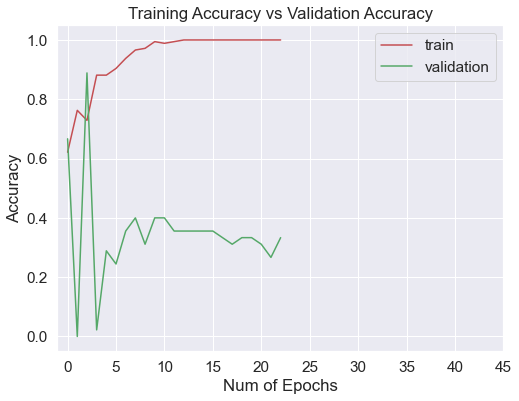

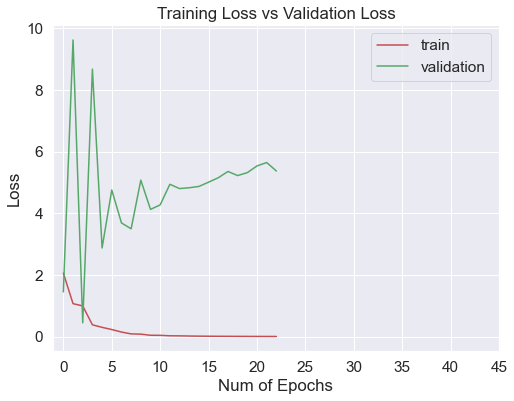

In [38]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()

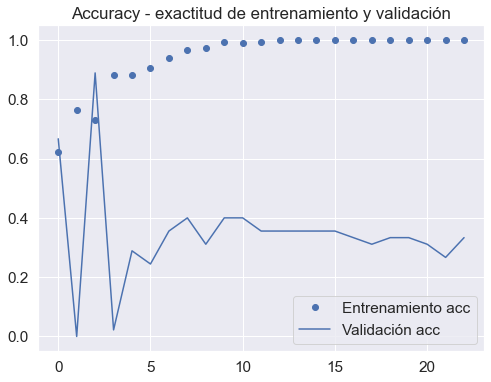

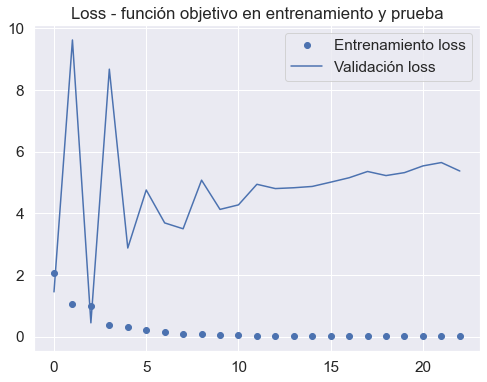

In [39]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 4s 949ms/step


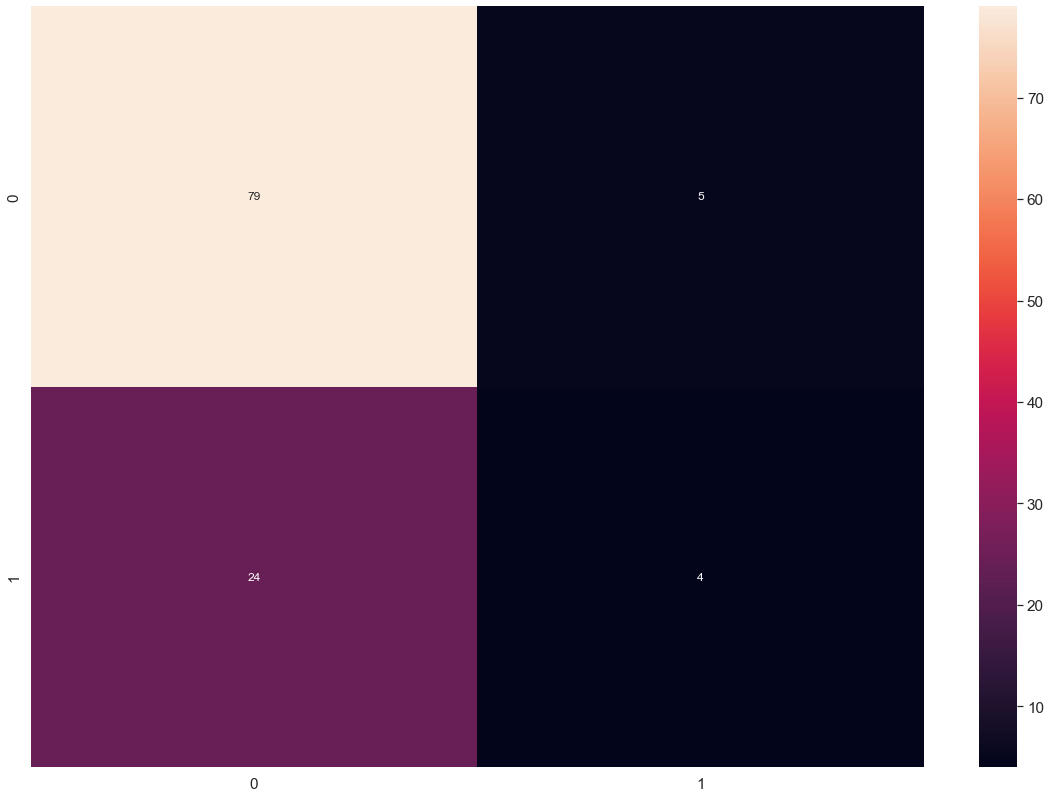

In [40]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

**MÉTRICAS DE EVALUACIÓN**

In [41]:
score_test = model.evaluate(x=test_ds, y=test_labels, verbose = 0)

print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 1.1265323162078857
Test accuracy: 0.7410714030265808


In [42]:
predictions = model.predict(test_ds)

4/4 [==============================] - 3s 775ms/step


In [43]:
roc_score = roc_auc_score(test_labels, predictions, multi_class='ovr')

print(roc_score)

0.659438775510204


In [44]:
snn_predicted = np.argmax(predictions, axis=1)
snn_report = classification_report(np.argmax(test_labels, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.77      0.94      0.84        84
           1       0.44      0.14      0.22        28

    accuracy                           0.74       112
   macro avg       0.61      0.54      0.53       112
weighted avg       0.69      0.74      0.69       112

